In [ ]:
!pip install -q transformers datasets



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np


#nlp = spacy.load(r'C:\Users\anagrecha\Anaconda3\envs\spacy_env\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.0.0')

df = pd.read_csv(r'/content/pjs_all.csv', nrows = 10000)

#df = df.head(5000)

print(df.info())
# df['csat'] = df['csat'].astype(int)
# df['Positive'] = df['csat']

# df['Negative'] = np.where(df['csat'] == 1,0,1)

df['nps'] = df['nps'].replace('10 (Extremely likely)',10)
df['nps'] = df['nps'].replace('0 (Not at all likely)',0)
df['nps'] = df['nps'].astype(int)

#target variable will nps split into demoters, passives and promoters
df['nps_group'] = np.where(df['nps'] >= 9,2,
                  np.where(df['nps'] <= 6,0,1))

#df['nps_group'] = np.where(df['nps'] >= 9,1,0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   ticket      10000 non-null  object
 2   nps         10000 non-null  object
 3   response    10000 non-null  object
 4   csat        10000 non-null  int64 
 5   date        10000 non-null  object
 6   length      10000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 547.0+ KB
None


In [ ]:
#df.info()

gb = df.groupby('nps_group')['nps'].count()
gb

nps_group
0    2048
1    1550
2    6402
Name: nps, dtype: int64

In [ ]:
# #calculating class weights
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight(class_weight = 'balanced', classes = [2,1,0], y = df['nps_group'])
# class_weights

df1 = df[df['nps_group'] == 0].head(15696)
df2 = df[df['nps_group'] == 1].head(15696)
df3 = df[df['nps_group'] == 2].head(15696)

df = pd.concat([df1,df2,df3], axis = 0)

gb = df.groupby('nps_group')['nps'].count()
gb

nps_group
0    15696
1    15696
2    15696
Name: nps, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['response'],df['nps_group'], test_size = 0.33, random_state=42)


In [ ]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['response'] = df['response'].apply(lambda x: text_preprocessing(x))
df


,Unnamed: 0,ticket,nps,response,csat,date,length,nps_group
0,216015,EUZRE945,1,Really bad delay for 3.5 hours,0,2023-04-10 12:30:00.000,6,0
1,218221,EUZUV812,10,Unfortunately i was unable to travel because o...,1,2023-03-27 12:00:00.000,88,2
2,217841,EUZUD179,0,I wanted to cancel but was not able to,0,2023-03-08 14:30:00.000,8,0
3,217346,EUZTH784,10,Easy to change,0,2023-02-24 17:55:00.000,3,2
4,14192,EUAMJY17,10,Unfortunately I was unable to travel as I was ...,1,2023-02-10 07:20:00.000,32,2
...,...,...,...,...,...,...,...,...
9995,7916,EUAGAF38,10,Comfortable ride. Happy to know you can book s...,1,2023-01-12 12:00:00.000,24,2
9996,16814,EUAPSX21,9,"Easy journey, on time and the driver was very ...",1,2023-01-12 12:00:00.000,9,2
9997,17638,EUARNM86,10,It is cheaper than using a car or train. You s...,1,2023-01-12 11:50:00.000,56,2
9998,218711,EUZVR766,10,"Excellent service. Very comfortable, on time, ...",1,2023-01-12 11:45:00.000,7,2


In [ ]:
from transformers import BertTokenizer
import torch
# imports the torch_xla package
#import torch_xla
#import torch_xla.core.xla_model as xm

tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)
#device = xm.xla_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else print("cpu"))
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
torch.cuda.memory_summary(device=device, abbreviated=False)
torch.cuda.empty_cache()

KeyError: ignored

In [ ]:
#need to specify the maximum string length from responses
responses = df['response'].to_numpy()
# Encode our concatenated data
encoded_response = [tokenizer.encode(sent, add_special_tokens=True) for sent in responses]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_response])
print('Max length: ', max_len)

Max length:  494


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 490

# # Print sentence 0 and its encoded token ids
# token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
# print('Original: ', X_train[0])
# print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_test)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.to_numpy())
val_labels = torch.tensor(y_test.to_numpy())

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)



In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits



CPU times: user 50.2 ms, sys: 2.98 ms, total: 53.1 ms
Wall time: 54.1 ms


In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on CPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.808565   |     -      |     -     |   28.92  
   1    |   40    |   0.649727   |     -      |     -     |   24.90  
   1    |   60    |   0.581420   |     -      |     -     |   25.41  


KeyboardInterrupt: ignored

In [ ]:
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
type(bert_classifier)

__main__.BertClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


AUC: nan
Accuracy: 100.00%


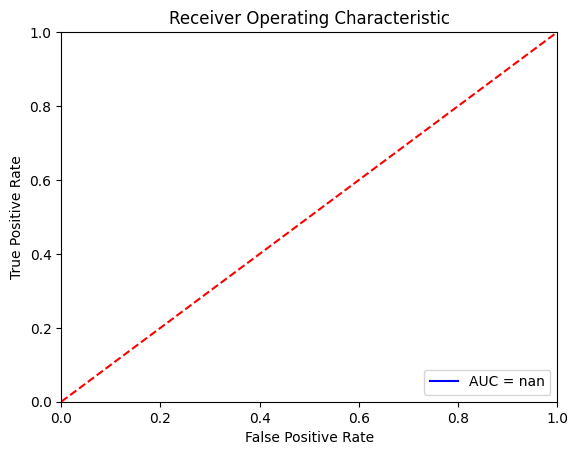

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)

In [ ]:
import torch.optim as optim

In [ ]:
#### Saving ###
from google.colab import drive
drive.mount('/content/gdrive')
#%cd /content/gdrive/My\ Drive/FOLDER

Mounted at /content/gdrive


saving the model

In [ ]:
model_save_name = 'bert_classifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
#path = F"/Shared drives/CRM & Insight/Analysis/arun/Text_Analytics"
torch.save(bert_classifier.state_dict(), path)

In [ ]:
print('completed')

In [ ]:
model_save_name = 'bert_classifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
bert_classifier.load_state_dict(torch.load(path))

In [ ]:
#model = TheModelClass(*args, **kwargs)
model = torch.load('PJS_optimised_BERT.pt')
model.eval()

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

Producing probabilities for a selection of random PJS responses.

In [ ]:
df_test

,Unnamed: 0,ticket,nps,response,csat,date,length
0,24371,EUBABJ31,10 (Extremely likely),"Very friendly driver, helped with information ...",1,55:00.0,16
1,24389,EUBADC13,9,Booking a trip is easy and the prices are comp...,1,30:00.0,9
2,20367,EUAUKG93,7,We used the bus as an alternative way to get i...,0,10:00.0,86
3,23990,EUAZFK49,4,Because the bus was over a hour late and I had...,0,10:00.0,73
4,24380,EUBACH13,10 (Extremely likely),The driver was so nice and helpful and the ove...,1,40:00.0,12
5,24381,EUBACH14,11 (Extremely likely),been using your service since about sept 2021....,1,40:00.0,13
6,24382,EUBACH15,12 (Extremely likely),Kind staff who boarded us onto the bus at Luto...,1,40:00.0,14
7,24383,EUBACH16,13 (Extremely likely),Despite a large number of people queueing and ...,1,40:00.0,15
8,24384,EUBACH17,14 (Extremely likely),Also bus arrived and left on time. Driver was ...,1,40:00.0,16
9,24385,EUBACH18,15 (Extremely likely),The only negative thing was the bus was to hot,1,40:00.0,17


In [ ]:
df_test = pd.read_csv('pjs_test2.csv')

# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(df_test['response'].to_numpy())

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)
preds
# # Number of tweets predicted non-negative
# print("Number of tweets predicted non-negative: ", preds.sum())

array([1, 0, 1, 1, 0, 1, 0])

In [ ]:
probs

array([[0.01195036, 0.9880497 ],
       [0.9331852 , 0.0668148 ],
       [0.01001221, 0.9899878 ],
       [0.01483019, 0.9851698 ],
       [0.94304025, 0.0569598 ],
       [0.02647644, 0.97352356],
       [0.80586725, 0.19413278]], dtype=float32)

In [ ]:
positive_probs = []
for x in probs:
  positive_probs.append(x[1])


In [ ]:
df_test['positive_prob'] = positive_probs
df_test

,Unnamed: 0,ticket,csat,response,nps,date,term,tier2,tier1,positive_prob
0,0,CSA03746,1,I think the driver was Kevin. Lgw to Lhr. An a...,10 (Extremely likely),2022-12-06 13:50:00,driver,Staff,People,0.961745
1,2,EUAAAA56,0,"My plane was delayed 2 hrs, I tried to call an...",0 (Not at all likely),2022-12-14 17:55:00,time,Time,Service,0.050272
2,2,EUAAAA56,0,"My plane was delayed 2 hrs, I tried to call an...",0 (Not at all likely),2022-12-14 17:55:00,delay,Time,Service,0.050272
3,2,EUAAAA56,0,"My plane was delayed 2 hrs, I tried to call an...",0 (Not at all likely),2022-12-14 17:55:00,journey,Journey,Service,0.050272
4,2,EUAAAA56,0,"My plane was delayed 2 hrs, I tried to call an...",0 (Not at all likely),2022-12-14 17:55:00,wait,Time,Service,0.050272
...,...,...,...,...,...,...,...,...,...,...
4995,2563,EUABSW71,0,"Return journey was a, completely different exp...",7,2022-12-16 10:00:00,time,Time,Service,0.088321
4996,2563,EUABSW71,0,"Return journey was a, completely different exp...",7,2022-12-16 10:00:00,late,Time,Service,0.088321
4997,2563,EUABSW71,0,"Return journey was a, completely different exp...",7,2022-12-16 10:00:00,delay,Time,Service,0.088321
4998,2563,EUABSW71,0,"Return journey was a, completely different exp...",7,2022-12-16 10:00:00,journey,Journey,Service,0.088321


In [ ]:
df_test.to_csv('df_sentiment.csv')

Do not remove the cell below

In [ ]:
probs

array([[0.01142652, 0.98857355],
       [0.0308141 , 0.9691859 ],
       [0.9498075 , 0.05019248],
       [0.9648847 , 0.03511536],
       [0.01201762, 0.9879824 ],
       [0.36469167, 0.63530827],
       [0.01291479, 0.98708516],
       [0.01533517, 0.98466486],
       [0.01382301, 0.986177  ],
       [0.05338982, 0.9466102 ],
       [0.01530475, 0.98469526],
       [0.93953013, 0.06046986]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
